In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from time import time
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(12,8)})

# mne import
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn)
from mne.time_frequency import AverageTFR
from mne.channels import make_standard_montage
from mne.decoding import LinearModel, Vectorizer, get_coef, Scaler, CSP, SPoC, UnsupervisedSpatialFilter
from mne.time_frequency import psd_welch
mne.set_log_level('WARNING')

import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
# random forest
def rfc(data):
    x = data[[*np.arange(0, len(epochs_data[0]))]]
    y = data['label'].astype('int64')

    x_train,x_test,y_train,y_test = train_test_split(x,y)

    rfc = RandomForestClassifier().fit(x_train,y_train)
    return rfc.score(x_test, y_test)

In [3]:
# svm
def svm(data):
    x = data[[*np.arange(0, len(epochs_data[0]))]]
    y = data['label'].astype('int64')

    scaler = StandardScaler()
    scaler.fit(x)
    x= scaler.transform(x)

    x_train,x_test,y_train,y_test = train_test_split(x,y)

    svc = SVC().fit(x_train,y_train)
    return svc.score(x_test, y_test)

In [4]:
dates = [720,721,723,724,725,726,727,728,729,730,731,731,801,801,802,804,804]
persons = ['dzq','zyy','wsy','lzz','fcx','zjs','thn','lj','cs','lzr','hyb','wzx','tjq','cfl','lpy','dzq2','lgm']
nums = [3, 5, 4, 6, 5, 7, 4, 3, 3, 6, 4, 6, 5, 6, 6, 4, 6]

[0.9488245642091796]
[0.9488245642091796, 0.9644970414201184]
[0.9488245642091796, 0.9644970414201184, 0.9445555111288818]
[0.9488245642091796, 0.9644970414201184, 0.9445555111288818, 0.9381932621369241]
[0.9488245642091796, 0.9644970414201184, 0.9445555111288818, 0.9381932621369241, 0.9455752641271687]
[0.9488245642091796, 0.9644970414201184, 0.9445555111288818, 0.9381932621369241, 0.9455752641271687, 0.9142192497819134]
i = 0 -- done


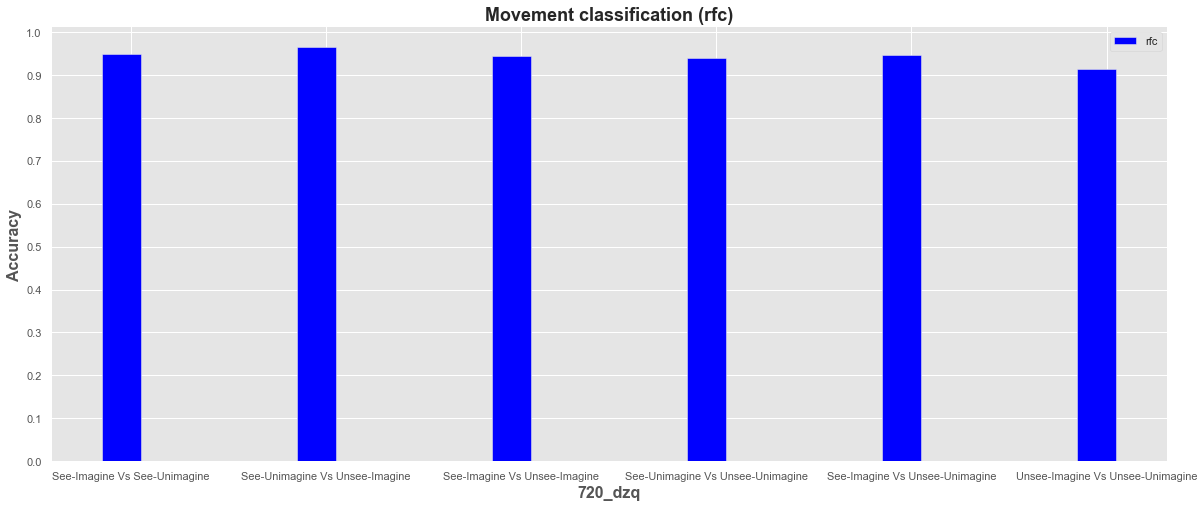

In [5]:
%matplotlib inline
for i in range(len(persons)):
    person = persons[i]
    num = nums[i]
    date = dates[i]
    raw = []
    # import data
#     for j in range(num):
    f = "E:\大创\data\EEG/0{}{}_eyesImagine{}-edf-pre.edf".format(date, person, 1)
    raw_files = read_raw_edf(f, preload=True, stim_channel='auto')
    raw.append(raw_files)
    # data preprocess
    raw = concatenate_raws(raw)
    events, event_dict = mne.events_from_annotations(raw)
    subkey = ['S  1','S  2','S  3','S 10']
    event_ids = dict([(key, event_dict[key]) for key in subkey])
    event_id_compose = [{'S  1':event_ids['S  1'], 'S  2':event_ids['S  2']},
                {'S  1':event_ids['S  1'], 'S  3':event_ids['S  3']},
                {'S  2':event_ids['S  2'], 'S  3':event_ids['S  3']},
                {'S  1':event_ids['S  1'], 'S 10':event_ids['S 10']},
                {'S  2':event_ids['S  2'], 'S 10':event_ids['S 10']},
                {'S  3':event_ids['S  3'], 'S 10':event_ids['S 10']}]
    acc = []
    # model train & fit & predict
    for event_id in event_id_compose:
        tmin, tmax = -0.5, 4.5
        picks = pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False)
        epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
        epochs_data = epochs.get_data()
        labels = epochs.events[:, -1]
        temp = labels.min()
        labels = labels - temp
        data = pd.DataFrame(columns=[*np.arange(0, len(epochs_data[0])), 'label'])
        for k in range(len(epochs_data)):
            tmp = pd.DataFrame(epochs_data[k]).transpose()
            tmp['label'] = labels[k]
            data = pd.concat([data, tmp], axis=0)

        acc.append(rfc(data))
        print(acc)
#         acc.append(svm(data))
#         print(acc)

    # result visualization
    plt.style.use("ggplot")
    states = ["See-Imagine Vs See-Unimagine", "See-Unimagine Vs Unsee-Imagine","See-Imagine Vs Unsee-Imagine",\
             "See-Unimagine Vs Unsee-Unimagine","See-Imagine Vs Unsee-Unimagine","Unsee-Imagine Vs Unsee-Unimagine"]
#     rfc_r = acc[::2]
#     svm_r = acc[1::2]
    xticks = np.arange(len(states))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(xticks, acc, width=0.2, label="rfc", color="blue")
#     ax.bar(xticks + 0.2, svm_r, width=0.2, label="svm", color="blue")
    ax.set_title("Movement classification (rfc)", fontsize=18, fontweight='heavy')
    ax.set_xlabel("{}_{}".format(date,person), fontsize=16, fontweight='heavy')
    ax.set_ylabel("Accuracy", fontsize=16, fontweight='heavy')
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.legend()
    # 最后调整x轴标签的位置
    ax.set_xticks(xticks + 0.05)
    ax.set_xticklabels(states)
#     plt.savefig("E:/大创/result_脑电/flatted_{}_{}".format(date,person), bbox_inches='tight')
    print('i = {} -- done'.format(i))
    break